<a href="https://colab.research.google.com/github/Wanludrame/Neural-Network-with-TensorFlow/blob/master/Time_series_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 116kB/s 
     |████████████████████████████████| 501kB 43.0MB/s 
     |████████████████████████████████| 3.1MB 20.9MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2019-12-18 18:58:31--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2019-12-18 18:58:31 (2.66 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



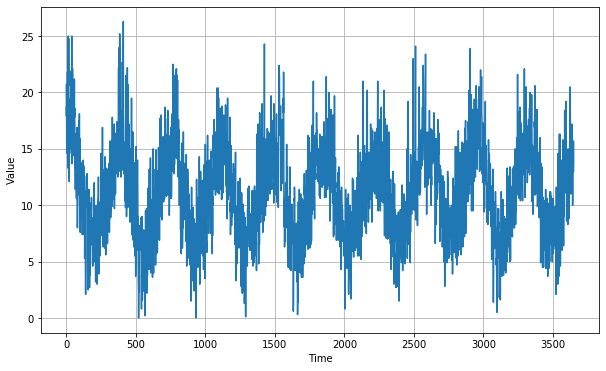

In [0]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step = 0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step += 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda x: (x[:-1], x[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(12)
np.random.seed(12)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 7s 687ms/step - loss: 15.9442 - mae: 16.4133
Epoch 2/100
10/10 [==============================] - 4s 412ms/step - loss: 14.6818 - mae: 15.1679
Epoch 3/100
10/10 [==============================] - 4s 416ms/step - loss: 12.8026 - mae: 13.2920
Epoch 4/100
10/10 [==============================] - 4s 414ms/step - loss: 10.7375 - mae: 11.2202
Epoch 5/100
10/10 [==============================] - 4s 415ms/step - loss: 9.1358 - mae: 9.6068
Epoch 6/100
10/10 [==============================] - 4s 417ms/step - loss: 8.3214 - mae: 8.7945
Epoch 7/100
10/10 [==============================] - 4s 426ms/step - loss: 7.9459 - mae: 8.4246
Epoch 8/100
10/10 [==============================] - 4s 422ms/step - loss: 7.7215 - mae: 8.2046
Epoch 9/100
10/10 [==============================] - 4s 414ms/step - loss: 7.5324 - mae: 8.0182
Epoch 10/100
10/10 [======

[1e-08, 0.0001, 0, 60]

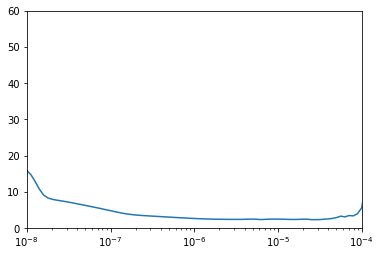

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(12)
np.random.seed(12)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=200)

Epoch 1/200
25/25 [==============================] - 8s 316ms/step - loss: 6.0349 - mae: 6.5818
Epoch 2/200
25/25 [==============================] - 5s 209ms/step - loss: 3.3637 - mae: 3.8578
Epoch 3/200
25/25 [==============================] - 5s 210ms/step - loss: 2.9833 - mae: 3.4589
Epoch 4/200
25/25 [==============================] - 5s 213ms/step - loss: 2.8027 - mae: 3.2718
Epoch 5/200
25/25 [==============================] - 5s 212ms/step - loss: 2.4570 - mae: 2.9212
Epoch 6/200
25/25 [==============================] - 5s 215ms/step - loss: 2.6397 - mae: 3.1122
Epoch 7/200
25/25 [==============================] - 5s 215ms/step - loss: 2.5313 - mae: 2.9899
Epoch 8/200
25/25 [==============================] - 5s 217ms/step - loss: 2.5657 - mae: 3.0359
Epoch 9/200
25/25 [==============================] - 5s 217ms/step - loss: 2.5004 - mae: 2.9651
Epoch 10/200
25/25 [==============================] - 5s 217ms/step - loss: 2.5819 - mae: 3.0520
Epoch 11/200
25/25 [===================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

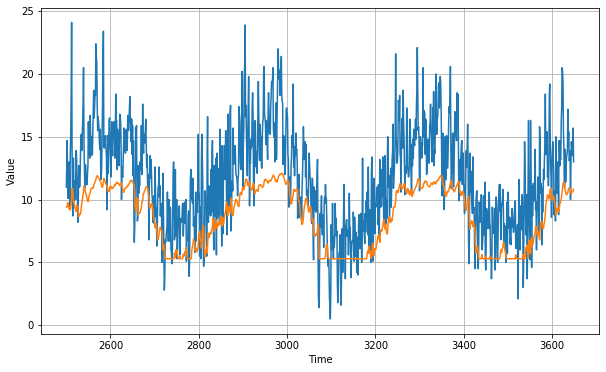

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

3.3828044

In [0]:
print(rnn_forecast)

[ 9.415846  9.402701  9.464509 ... 10.647352 10.67221  10.825489]
